In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline


# read in train and holdout
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

# first 5 rows: holdout
print(holdout.head(n=5))

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [233]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [234]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for dummy in ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]:
        df = create_dummies(df, dummy)
    return df

train = process_df(train)
holdout = process_df(holdout)


    

SibSp : int64
SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64


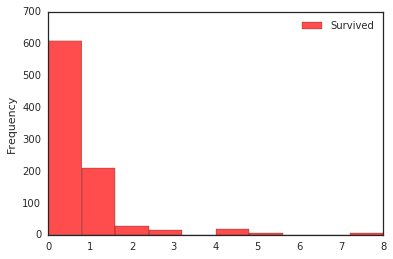

Parch : int64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


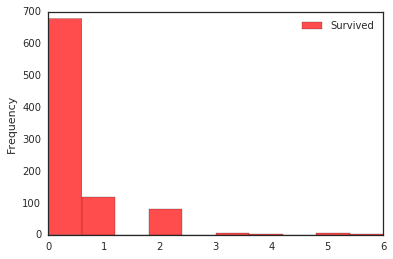

In [235]:
for col in ["SibSp", "Parch"]:
    print(str(col), ":", train[col].dtype)
    print(train.pivot_table(index=col, values="Survived"))
    train[col].plot.hist(alpha=0.7, color="red")
    plt.legend(["Survived"])
    plt.show()
    

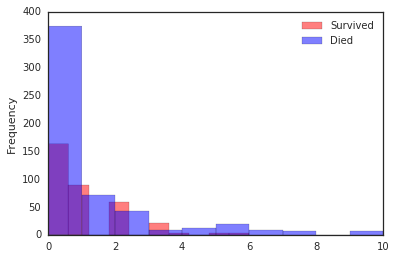

In [236]:
train["family_size"] = train["SibSp"] + train["Parch"]
holdout["family_size"] = holdout["SibSp"] + holdout["Parch"]

died = train[train["Survived"] == 0]
survived = train[train["Survived"] == 1]

survived["family_size"].plot.hist(alpha=0.5, color="red")
died["family_size"].plot.hist(alpha=0.5, color="blue")
plt.legend(["Survived", "Died"])
plt.show()



In [237]:
print("Survived: ")
print(train.pivot_table(index="family_size", values="Survived"))



Survived: 
family_size
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64


In [238]:
"""
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=col,values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()
"""

'\nexplore_cols = ["SibSp","Parch","Survived"]\nexplore = train[explore_cols].copy()\n\nexplore[\'familysize\'] = explore[["SibSp","Parch"]].sum(axis=1)\npivot = explore.pivot_table(index=col,values="Survived")\npivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))\nplt.show()\n'

30% of the people who traveled alone have actually survived. 
More than 3 family members are actually bad for survival. 

In [239]:
def is_alone(df):
    df["isalone"] = df["family_size"].apply(lambda x: 1 if x == 0 else 0)
    df = df.drop(["SibSp", "Parch"], axis=1)
    return df

train = is_alone(train)
holdout = is_alone(holdout)



In [240]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived", "PassengerId"], axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    return best_columns

best_features = select_features(train)
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_features))



Best Columns 
------------
['Pclass', 'Age', 'Fare', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Mr', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family_size', 'isalone']



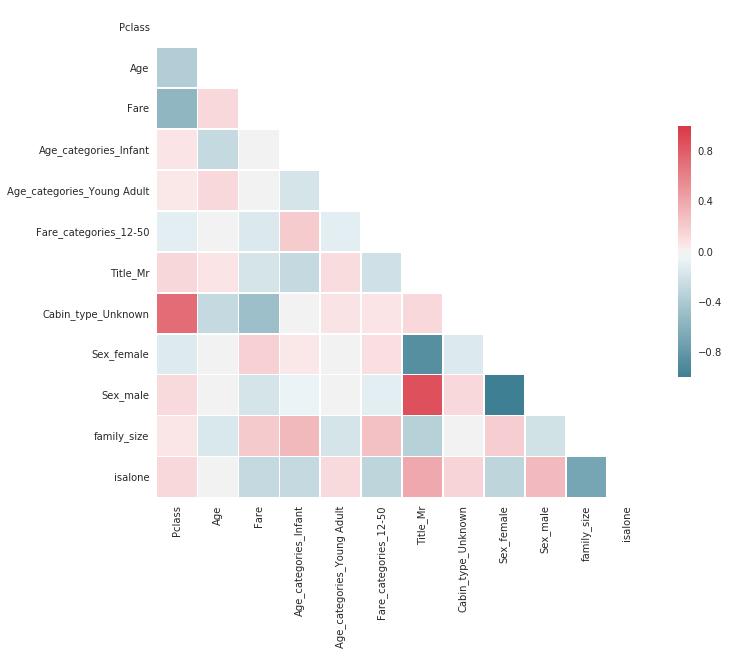

['Pclass', 'Age', 'Fare', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Mr', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family_size', 'isalone']


In [241]:
# print(train[best_features].corr())

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(train[best_features])



print(best_features)   



In [242]:
def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    
    model_list = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    
    for model in model_list:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
        print("Best Model: {}\n".format(model["best_model"]))
    return model_list

result = select_model(train, best_features)



LogisticRegression
------------------
Best Score: 0.813692480359147
Best Parameters: {'solver': 'liblinear'}

Best Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

Best Model: KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=1,
           weights='distance')

RandomForestClassifier
----------------------
Best Score: 0.8383838383838383
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 9, 'min_samples_leaf': 1, 'min_samples_split': 5}

Best Model: RandomForestClassifier(b

In [243]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_predictions = model.predict(holdout[cols])
    submission = pd.DataFrame({
        "PassengerId": holdout["PassengerId"],
        "Survived": holdout_predictions
    })
    submission.to_csv(filename, index=False)
    
best_model = result[2]["best_model"]

save_submission_file(best_model, best_features)